<a href="https://colab.research.google.com/github/Sonya112/Unsupervised-Learning/blob/master/Copy_of_attachment_CNN_aliens_predators_seq_with_preprocessing_lyst3935.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aliens vs Predators

In this notebook, we will try to classify some extraterrestrial beings!<br>

We have provided a dataset of 899 images of Aliens and Predators and we need to build a Convolutional Neural Network classifier to classify the two images.

The images have been provided with the following link.
https://www.dropbox.com/s/bvp753qskbaz20z/alien-vs-predator-images.zip

They have been split into folder structures of train and validation each containing folders for images of aliens and predators. Lets get started! 

## Table of Contents

1. [Downloading the dataset](#download)
2. [Unzip the dataset](#unzip)
3. [Importing the packages](#import)
4. [Batch Processing Images](#batch)
5. [Build the model](#build)
6. [Train the model](#train)
7. [Save the trained model](#save)
8. [Visualizing the Training and Validation Loss at every epoch](#visualize)

## 1. Downloading the dataset  <a id='download'>

In [0]:
!wget -q https://www.dropbox.com/s/bvp753qskbaz20z/alien-vs-predator-images.zip

### 2. Unzip the dataset   <a id='unzip'>

In [0]:
!unzip alien-vs-predator-images.zip > /dev/null; echo " done."

 done.


In [0]:
!ls -R | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/'

   .
   |-alien-vs-predator-images
   |---data
   |-----train
   |-------alien
   |-------predator
   |-----validation
   |-------alien
   |-------predator
   |-sample_data


## 3. Importing packages   <a id='import'>

In [0]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Setting the seed

tf.reset_default_graph()
tf.set_random_seed(12)

## 4. Batch Processing of Images   <a id='batch'>

Using ImageDataGenerator, we will read the images using flow_from_directory.<br>
We will perform basic image processing techniques on train data such as:
- Rescaling
After this, we will convert the images into 150x150 pixel color images for training.<br>
These images will be passed to the model with batch size of 32.

In [0]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
      rescale=1./255.,
      vertical_flip=True, 
      horizontal_flip=True,
      rotation_range=10, 
      zoom_range=0.25,
      shear_range=0.45, 
      fill_mode='nearest'
)

val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
        'alien-vs-predator-images/data/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        'alien-vs-predator-images/data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
 


Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


alien


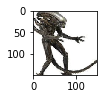

predator


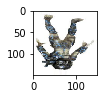

predator


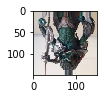

In [0]:
#Display images from training folder
# **add subplot in the below fig
x,y = train_generator.next()

for i in range(0,3):
    image = x[i]
    label = y[i]
    plt.subplot2grid((3,3),(1,i))
    print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(label))])
    plt.imshow(image)
    plt.show()
    


## 5. Build the model  <a id='build'>

After preprocessing the image the time has come to build our Convolutional Neural Network Classifier which can classify the images of Aliens and Predators. We will use a lot of different types of layers to build our model such as 
- Convolutional layer
- Max Pooling layer
- Dense layer

We will use Adam as our optimizer. <br>.

In [0]:
# clear the current tensorflow graph and create new one
tf.keras.backend.clear_session()

#Build model
model = tf.keras.models.Sequential()

##32 filters of 3x3 size. The input images are 150x150x3. Activation=relu and padding=same

model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# Flatten all the feature maps
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# Fully connected neural network for prediction
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We will train our model for 50 epochs, which means it will perform 50 times forward and back propagation.  <br>
Learning rate has been set to 0.0001 so that the model converges very slowly.  <br>

Categorical crossentropy is our loss function which is used for two or more classes. You can also try 'binary_crossentropy'.<br>
We will minimize the loss function with Adam optimizer.<br>

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Lets observe the model we have built and the summary of all the layers in the model.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0

We will define two callbacks:
- checkpoint: to save the best weights when validation accuracy increases
- tensorboard visualization

In [0]:
# checkpoint
filepath="weights.aliens.preprocess.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [0]:
"""
Tensorboard log
"""
log_dir = './tf-log/alien_v4'
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## 6. Tensorboard visualization

In [0]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
# start tensorboard on localhost 6006

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [0]:
# start ngrok and asking ngrok to forward to port to 6006 where tensorboard is running 
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
# get url generated from ngrok

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://2472a693.ngrok.io


## 7. Train the model   <a id='train'>

In [0]:
batch_size = 32

fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(train_generator.samples) // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps= int(validation_generator.samples) // batch_size,
        callbacks=[tb_cb,checkpoint]
        )

Epoch 1/50
 6/21 [=======>......................] - ETA: 1s - loss: 0.6712 - acc: 0.6302
Epoch 00001: val_acc improved from -inf to 0.63021, saving model to weights.aliens.preprocess.best.hdf5
21/21 [==============================] - 9s 408ms/step - loss: 0.8847 - acc: 0.5227 - val_loss: 0.6712 - val_acc: 0.6302
Epoch 2/50
 6/21 [=======>......................] - ETA: 1s - loss: 0.6731 - acc: 0.6719
Epoch 00002: val_acc improved from 0.63021 to 0.67188, saving model to weights.aliens.preprocess.best.hdf5
21/21 [==============================] - 6s 266ms/step - loss: 0.6409 - acc: 0.6329 - val_loss: 0.6731 - val_acc: 0.6719
Epoch 3/50
 6/21 [=======>......................] - ETA: 1s - loss: 0.6682 - acc: 0.5990
Epoch 00003: val_acc did not improve from 0.67188
21/21 [==============================] - 5s 240ms/step - loss: 0.6091 - acc: 0.6964 - val_loss: 0.6682 - val_acc: 0.5990
Epoch 4/50
 6/21 [=======>......................] - ETA: 1s - loss: 0.6283 - acc: 0.7083
Epoch 00004: val_acc

In [0]:
batch_size = 32

fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(train_generator.samples) // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps= int(validation_generator.samples) // batch_size,
        callbacks=[tb_cb,checkpoint],
        initial_epoch=50
        )

Epoch 51/100
 6/21 [=======>......................] - ETA: 1s - loss: 0.5701 - acc: 0.7917
Epoch 00051: val_acc did not improve from 0.80729
21/21 [==============================] - 5s 248ms/step - loss: 0.3361 - acc: 0.8474 - val_loss: 0.5701 - val_acc: 0.7917
Epoch 52/100
 6/21 [=======>......................] - ETA: 1s - loss: 0.5549 - acc: 0.7604
Epoch 00052: val_acc did not improve from 0.80729
21/21 [==============================] - 5s 240ms/step - loss: 0.3125 - acc: 0.8640 - val_loss: 0.5549 - val_acc: 0.7604
Epoch 53/100
 6/21 [=======>......................] - ETA: 1s - loss: 0.5554 - acc: 0.7865
Epoch 00053: val_acc did not improve from 0.80729
21/21 [==============================] - 5s 234ms/step - loss: 0.3324 - acc: 0.8459 - val_loss: 0.5554 - val_acc: 0.7865
Epoch 54/100
 6/21 [=======>......................] - ETA: 1s - loss: 0.5450 - acc: 0.7656
Epoch 00054: val_acc did not improve from 0.80729
21/21 [==============================] - 5s 235ms/step - loss: 0.3607 - a

In [0]:
batch_size = 32

fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(train_generator.samples) // batch_size,
        epochs=150,
        validation_data=validation_generator,
        validation_steps= int(validation_generator.samples) // batch_size,
        callbacks=[tb_cb,checkpoint],
        initial_epoch=100
        )

Epoch 101/150
 6/21 [=======>......................] - ETA: 1s - loss: 0.7184 - acc: 0.8125
Epoch 00101: val_acc did not improve from 0.83854
21/21 [==============================] - 5s 249ms/step - loss: 0.1789 - acc: 0.9305 - val_loss: 0.7184 - val_acc: 0.8125
Epoch 102/150
 6/21 [=======>......................] - ETA: 1s - loss: 0.7453 - acc: 0.8385
Epoch 00102: val_acc did not improve from 0.83854
21/21 [==============================] - 5s 251ms/step - loss: 0.2024 - acc: 0.9260 - val_loss: 0.7453 - val_acc: 0.8385
Epoch 103/150
 6/21 [=======>......................] - ETA: 1s - loss: 0.8896 - acc: 0.8177
Epoch 00103: val_acc did not improve from 0.83854
21/21 [==============================] - 5s 242ms/step - loss: 0.2026 - acc: 0.9154 - val_loss: 0.8896 - val_acc: 0.8177
Epoch 104/150
 6/21 [=======>......................] - ETA: 1s - loss: 0.8520 - acc: 0.8125
Epoch 00104: val_acc did not improve from 0.83854
21/21 [==============================] - 5s 249ms/step - loss: 0.1725

# 8.Model Prediction

In [0]:
def predict_image(model,image_file_name):
  
  classifier=model

  img = tf.keras.preprocessing.image.load_img(image_file_name,target_size=(150, 150))
  img_arr = tf.keras.preprocessing.image.img_to_array(img)/255

  x=img_arr.reshape(1,150,150,3) 
  plt.imshow(img)

  result = classifier.predict(x)
  print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(result))])

In [0]:
#Download new image for prediction

!wget -q https://www.dreadcentral.com/wp-content/uploads/2018/06/Predator-1.jpg

!wget -q https://www.bleedingcool.com/wp-content/uploads/2018/06/NECA-Predator-2018-Film-Figure-3.jpg
  
!wget -q https://cdn.shopify.com/s/files/1/0474/7237/products/neca-alien-avp-series-7-warrior-alien-9-action-figure-pre-order-ships-april-2_1024x1024.jpg

predator


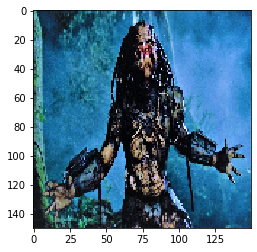

In [0]:
predict_image(model,'Predator-1.jpg')

predator


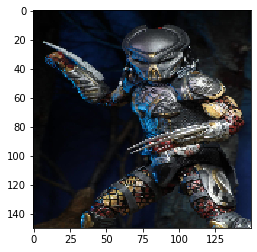

In [0]:
predict_image(model,'NECA-Predator-2018-Film-Figure-3.jpg')

alien


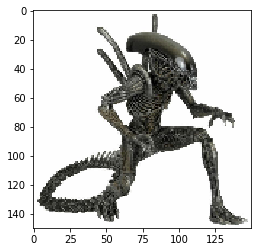

In [0]:
predict_image(model,'neca-alien-avp-series-7-warrior-alien-9-action-figure-pre-order-ships-april-2_1024x1024.jpg')